In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

In [6]:
df = pd.read_csv('dataset/opsd_raw.csv')
print(df.shape)

(50400, 99)


In [7]:
# Columns for Denmark
cols_to_drop = [x for x in df.columns if 
                x != 'DK_load_actual_entsoe_transparency' and
                x != 'DK_solar_generation_actual' and
                x != 'DK_wind_generation_actual']

df.drop(columns=cols_to_drop, inplace=True)
print(df.isna().sum())

# Replace NaN's with the closest not NaN value
for col in df:
    temp = df.isna().any(axis=1)
    for i in temp[temp].index:
        for j in range(i+1, df[col].size):
            if not pd.isna(df[col][j]):
                df.loc[i, col] = df[col][j]
                break
        if not pd.isna(df[col][i]): continue

        for j in range(i-1, 0, -1):
            if not pd.isna(df[col][j]):
                df.loc[i, col]= df[col][j]
                break
print(df.shape)
print(df.isna().sum())
df.head(25)

DK_load_actual_entsoe_transparency     2
DK_solar_generation_actual            11
DK_wind_generation_actual              2
dtype: int64
(50400, 3)
DK_load_actual_entsoe_transparency    0
DK_solar_generation_actual            0
DK_wind_generation_actual             0
dtype: int64


,DK_load_actual_entsoe_transparency,DK_solar_generation_actual,DK_wind_generation_actual
0,3100.02,0.01,2357.33
1,2980.39,0.01,2357.33
2,2933.49,0.01,2387.35
3,2941.54,0.01,2594.47
4,2941.54,0.01,3092.01
5,2999.89,0.01,3270.63
6,3176.80,0.01,3502.55
7,3292.27,0.03,3706.07
8,3378.64,1.50,3847.48
9,3562.90,6.18,3867.69


In [8]:
# Split into 3 dataframes to make it easier to work with
empty_cells = np.arange(0, df['DK_load_actual_entsoe_transparency'].size, 1.0)
empty_cells = empty_cells.reshape(2100, 24)

power_load = pd.DataFrame(data=empty_cells.copy(),columns=[x for x in range(24)])
solar_generation = pd.DataFrame(data=empty_cells.copy(), columns=[x for x in range(24)])
wind_generation = pd.DataFrame(data=empty_cells.copy(), columns=[x for x in range(24)])

# Populate the dataframes with 24 hour records
for x in range(df['DK_load_actual_entsoe_transparency'].size):
    power_load.loc[x//24, x%24] = df['DK_load_actual_entsoe_transparency'][x]
    solar_generation.loc[x//24, x%24] = df['DK_solar_generation_actual'][x]
    wind_generation.loc[x//24, x%24] = df['DK_wind_generation_actual'][x]
    
# Delete original dataframe to save memory
del df
solar_generation

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.03,1.50,6.18,...,0.19,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.06,4.76,29.04,...,6.91,0.08,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.06,9.65,45.13,...,9.12,0.07,0.01,0.00,0.01,0.01,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.53,23.22,79.39,...,13.58,0.20,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.10,4.97,21.12,...,2.51,0.03,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,0.00,0.00,0.00,0.00,0.02,5.97,40.97,80.71,121.72,157.24,...,94.36,46.32,13.46,0.44,0.00,0.00,0.00,0.00,0.00,0.00
2096,0.00,0.00,0.00,0.00,0.02,3.92,31.11,85.29,170.86,280.95,...,234.08,104.12,25.04,0.58,0.00,0.00,0.00,0.00,0.00,0.00
2097,0.00,0.00,0.00,0.00,0.03,3.25,24.44,51.03,83.10,115.48,...,95.69,47.13,9.39,0.18,0.00,0.00,0.00,0.00,0.00,0.00
2098,0.00,0.00,0.00,0.00,0.02,7.54,70.72,179.59,294.36,408.75,...,206.21,97.06,16.35,0.22,0.00,0.00,0.00,0.00,0.00,0.00


In [9]:
wind_generation

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,2357.33,2357.33,2387.35,2594.47,3092.01,3270.63,3502.55,3706.07,3847.48,3867.69,...,3527.85,3632.61,3835.65,4069.17,4249.29,4349.40,4402.20,4409.94,4367.49,3886.06
1,3231.60,3212.27,3188.93,3167.60,3425.92,4297.12,4377.07,4389.64,4356.10,4314.20,...,4208.41,4193.58,4223.47,4247.63,4187.39,4050.00,4176.21,4149.19,3947.79,4018.59
2,4018.64,4039.56,3905.82,3714.39,3645.20,3574.32,3536.79,3444.29,3348.15,3197.43,...,2928.70,2850.35,2803.28,2797.39,2740.46,2765.90,2733.93,2775.21,2804.52,2766.54
3,2826.29,2846.83,2940.79,2938.14,2821.14,2789.49,2718.40,2767.87,2803.86,2869.17,...,2096.53,1966.14,1948.16,1973.56,2054.66,2069.12,2154.17,2257.10,2446.09,2344.00
4,2320.43,2210.96,1963.76,1741.78,1615.43,1413.26,1167.09,969.12,794.60,545.92,...,418.73,134.20,100.63,93.67,154.73,210.79,276.75,295.98,348.01,400.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,1051.63,1120.50,1200.78,1237.47,1142.70,1346.36,1379.61,1213.16,1176.99,1191.02,...,2063.43,2540.97,3156.52,3656.15,4082.32,3825.82,3982.72,3370.73,2992.93,3101.78
2096,3215.62,3381.11,3300.46,3059.72,3037.58,3066.55,2945.04,2946.78,2844.76,2705.12,...,2950.99,2878.50,2827.70,2815.01,2656.29,2318.37,2109.85,1962.87,1857.57,1805.69
2097,1636.71,1579.19,1508.15,1505.78,1492.45,1419.25,1404.68,1310.89,1193.81,985.98,...,603.76,510.55,508.08,657.70,589.16,520.93,535.28,494.76,467.58,492.68
2098,500.61,547.66,542.67,508.62,489.83,546.33,500.56,516.58,584.98,747.16,...,783.49,758.91,719.43,772.35,869.80,824.63,745.68,728.31,662.07,606.50


In [10]:
power_load

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,3100.02,2980.39,2933.49,2941.54,2941.54,2999.89,3176.80,3292.27,3378.64,3562.90,...,3985.15,4262.07,4495.76,4491.80,4290.82,4047.51,3857.01,3588.33,3412.59,3212.10
1,2996.22,2942.88,2944.18,3019.46,3104.17,3523.94,3868.58,4190.57,4337.33,4515.60,...,4429.72,4741.13,5178.70,5091.42,4725.76,4319.18,4131.82,3823.52,3530.62,3391.71
2,3277.54,3116.86,3041.39,3015.66,3078.47,3322.07,3636.03,3888.58,4062.27,4177.13,...,3967.88,4337.85,4825.59,4751.57,4325.66,4048.36,3792.96,3570.88,3377.74,3186.15
3,3058.45,2963.90,2949.49,2961.16,2977.69,3115.01,3343.84,3643.23,3897.32,4042.52,...,3974.44,4452.74,4939.97,4815.78,4470.47,4139.33,3909.80,3512.29,3348.25,3190.45
4,3079.55,2973.79,2944.50,3001.08,3311.06,4047.10,4814.13,5047.54,5088.35,5145.24,...,4912.72,5149.11,5524.92,5257.00,4904.15,4557.88,4230.98,3850.42,3486.25,3249.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,2707.49,2691.60,2714.08,2791.96,2967.06,3218.46,3542.44,3740.74,3843.37,3842.89,...,3751.91,4066.55,4107.39,3960.61,3768.22,3552.22,3368.82,3138.20,2919.33,2759.27
2096,2712.90,2635.47,2656.54,2738.73,2867.12,3070.74,3447.78,3614.78,3651.90,3678.97,...,3600.53,3997.44,4060.79,3977.45,3722.80,3430.83,3180.34,2988.29,2869.89,2749.45
2097,2683.38,2691.28,2717.85,3054.66,3592.30,4175.11,4408.01,4393.76,4478.20,4540.67,...,4226.07,4458.39,4385.67,4312.48,3989.59,3659.14,3327.38,3114.61,2879.81,2765.65
2098,2758.49,2786.04,2883.05,3062.49,3578.37,4089.92,4287.50,4318.30,4458.46,4456.72,...,4161.70,4433.15,4399.53,4358.41,4099.17,3793.50,3373.40,3107.03,2978.80,2865.30


In [11]:
data = pd.concat([wind_generation, power_load, solar_generation], axis=1)
data

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,2357.33,2357.33,2387.35,2594.47,3092.01,3270.63,3502.55,3706.07,3847.48,3867.69,...,0.19,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00
1,3231.60,3212.27,3188.93,3167.60,3425.92,4297.12,4377.07,4389.64,4356.10,4314.20,...,6.91,0.08,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00
2,4018.64,4039.56,3905.82,3714.39,3645.20,3574.32,3536.79,3444.29,3348.15,3197.43,...,9.12,0.07,0.01,0.00,0.01,0.01,0.00,0.00,0.00,0.00
3,2826.29,2846.83,2940.79,2938.14,2821.14,2789.49,2718.40,2767.87,2803.86,2869.17,...,13.58,0.20,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00
4,2320.43,2210.96,1963.76,1741.78,1615.43,1413.26,1167.09,969.12,794.60,545.92,...,2.51,0.03,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,1051.63,1120.50,1200.78,1237.47,1142.70,1346.36,1379.61,1213.16,1176.99,1191.02,...,94.36,46.32,13.46,0.44,0.00,0.00,0.00,0.00,0.00,0.00
2096,3215.62,3381.11,3300.46,3059.72,3037.58,3066.55,2945.04,2946.78,2844.76,2705.12,...,234.08,104.12,25.04,0.58,0.00,0.00,0.00,0.00,0.00,0.00
2097,1636.71,1579.19,1508.15,1505.78,1492.45,1419.25,1404.68,1310.89,1193.81,985.98,...,95.69,47.13,9.39,0.18,0.00,0.00,0.00,0.00,0.00,0.00
2098,500.61,547.66,542.67,508.62,489.83,546.33,500.56,516.58,584.98,747.16,...,206.21,97.06,16.35,0.22,0.00,0.00,0.00,0.00,0.00,0.00


In [12]:
# Label each day with a respective season. 
# (I know there is a date column but I only noticed it after writing this part of the code)
curr_year = 2014
num_of_days = len(data[0])
seasons_col = np.zeros(num_of_days)
print(num_of_days)
isVis = False
day = -1

for i in range(num_of_days):
    day = (day + 1) % (365 + isVis)
    curr_year += (day == 0)
    isVis = (curr_year % 4 == 0)
    
    if day == 0 and curr_year % 4 == 0: 
        curr_year += 1
        isVis += 1

    if 0 <= day <= (58 + isVis): #Jan-Feb
        seasons_col[i] = 0
    elif (58 + isVis) < day <= (150 + isVis): #Mar-May
        seasons_col[i] = 1
    elif (150 + isVis) < day <= (242 + isVis): #June-Aug
        seasons_col[i] = 2
    elif (242 + isVis) < day <= (333 + isVis): #Sep-Nov
        seasons_col[i] = 3
    else: #Dec
        seasons_col[i] = 0



2100


In [13]:
# Number of each season in the dataframe
# Print the number of occurrences for each season (0 to 3) in seasons_col
for season in range(4):
    print(f"Season {season}: {np.sum(seasons_col == season)}")

Season 0: 509
Season 1: 552
Season 2: 552
Season 3: 487


In [ ]:
# Split the daily records into train (70%), validation (15%), and test (15%) sets.
train_x, temp_x, train_y, temp_y = train_test_split(data, seasons_col, test_size=0.3, random_state=52)
val_x, test_x, val_y, test_y = train_test_split(temp_x, temp_y, test_size=0.5, random_state=52)

# Apply MinMaxScaler to all dataframes. 
# It was chosen because it gives way better results compared to StandardScaler with GAF transformation

# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
train_x = scaler.fit_transform(train_x)
val_x = scaler.transform(val_x)
test_x = scaler.transform(test_x)

print("Power Load - Train:", train_x.shape, "Validation:", val_x.shape, "Test:", test_x.shape)
# Save scaler to use for predictions in different application
joblib.dump(scaler, 'models/scaler.save')


Power Load - Train: (1470, 72) Validation: (315, 72) Test: (315, 72)


['models/scaler.save']

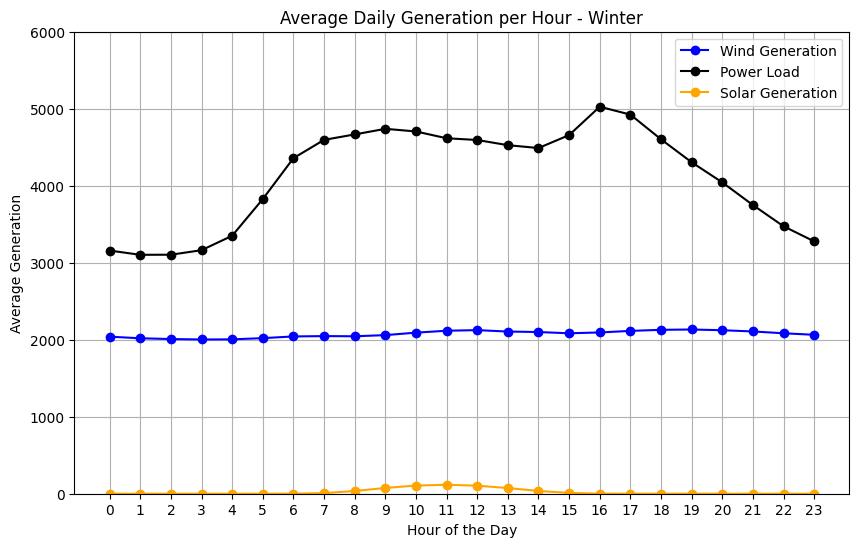

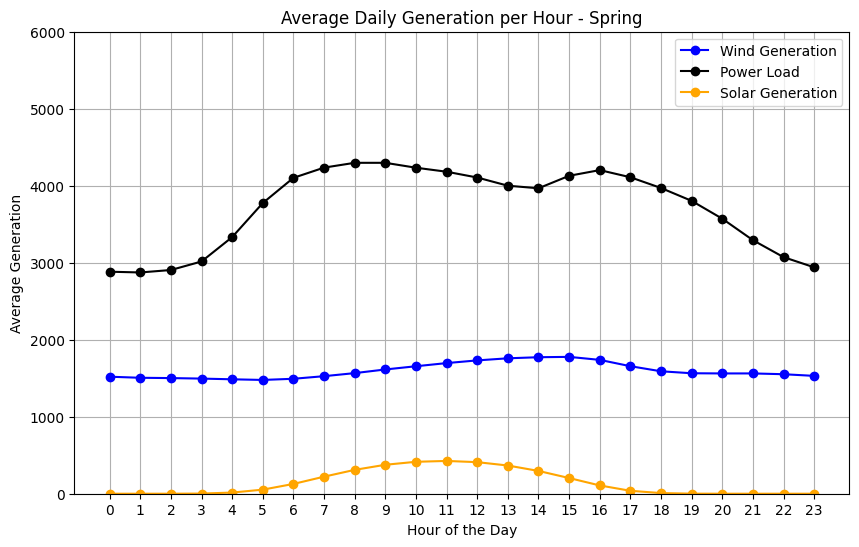

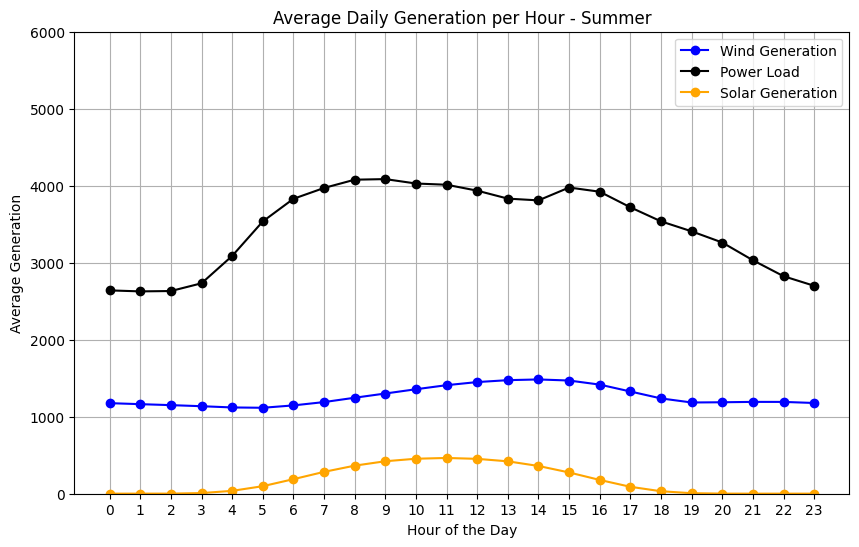

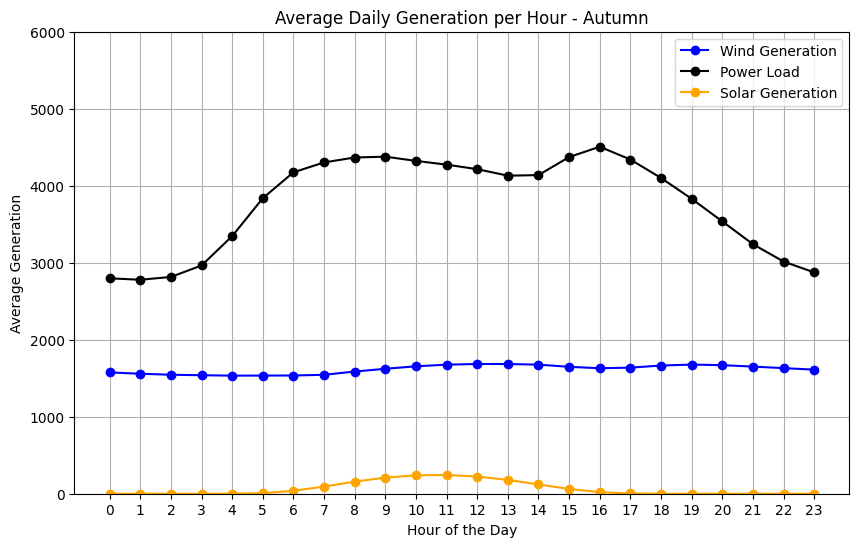

In [15]:
import matplotlib.pyplot as plt
# Plot one example of a average daily consumption profile for each season. 
season_names = {0: "Winter", 1: "Spring", 2: "Summer", 3: "Autumn"}


for season, name in season_names.items():
    season_data_wind = wind_generation[seasons_col == season].iloc[:, :24]
    avg_hourly_wind = season_data_wind.mean() 

    season_data_solar = solar_generation[seasons_col == season].iloc[:, :24]
    avg_hour_solar = season_data_solar.mean()

    season_data_power = power_load[seasons_col == season].iloc[:, :24]
    avg_hour_power = season_data_power.mean()
    
    # Plot the graph
    plt.figure(figsize=(10, 6))
    plt.ylim(0, 6000)
    plt.plot(avg_hourly_wind, marker='o', color='blue', label='Wind Generation')
    plt.plot(avg_hour_power, marker='o', color='black', label='Power Load')
    plt.plot(avg_hour_solar, marker='o', color='orange', label='Solar Generation')

    plt.legend(loc='upper right')
    
    plt.title(f"Average Daily Generation per Hour - {name}")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Average Generation")
    plt.xticks(range(24))
    plt.grid(True)
    
    plt.show()

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    # Input size is 72 because we have 3 days with 24 hours in each
    # Output size is 4 because we have 4 seaons to predict
    # Hidden size is 128 because it experimentally gave the best accuracy results
    def __init__(self, input_size=24*3, output_size=4, hidden_size=256):
        super(MLP, self).__init__()

        self.conv = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 3*hidden_size),
            nn.ReLU(),
            nn.Linear(3*hidden_size, output_size)
        )
    def forward(self, x):
        x = self.conv(x)
        return x
    

In [17]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# function to train a model
def train(model, criterion, optimizer, train_losses, val_accuracies, X_train, y_train, X_val, y_val, epochs):
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_preds = torch.argmax(val_outputs, dim=1)
            val_accuracy = accuracy_score(y_val.numpy(), val_preds.numpy())
            val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_preds = torch.argmax(test_outputs, dim=1) # Final “test set” predictions
        test_accuracy = accuracy_score(y_test.numpy(), test_preds.numpy())
    # for x in test_preds:
    #     print(season_names[x.item()])
    # print()
    return test_preds, test_accuracy
    
# function to plot training loss and validation accuracy
def plot(train_losses, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy Curve")
    plt.legend()

    plt.show()

# function to plot confusion matrix
def plot_confusion_matrix(y_test, test_preds):
    cm = confusion_matrix(y_test.numpy(), test_preds.numpy())

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Winter", "Spring", "Summer", "Autumn"])
    fig, ax = plt.subplots(figsize=(7, 6))
    disp.plot(cmap="Greens", values_format="d", colorbar=False, ax=ax)

    ax.set_xlabel("Predicted Season", fontsize=10)
    ax.set_ylabel("Actual Season", fontsize=10)

    plt.title("Confusion Matrix")
    plt.show()

Epoch 1/250, Loss: 1.3833, Val Accuracy: 0.4063
Epoch 2/250, Loss: 1.3490, Val Accuracy: 0.4952
Epoch 3/250, Loss: 1.3155, Val Accuracy: 0.4952
Epoch 4/250, Loss: 1.2797, Val Accuracy: 0.4921
Epoch 5/250, Loss: 1.2408, Val Accuracy: 0.4794
Epoch 6/250, Loss: 1.1989, Val Accuracy: 0.4984
Epoch 7/250, Loss: 1.1551, Val Accuracy: 0.5048
Epoch 8/250, Loss: 1.1114, Val Accuracy: 0.5175
Epoch 9/250, Loss: 1.0701, Val Accuracy: 0.5238
Epoch 10/250, Loss: 1.0332, Val Accuracy: 0.5365
Epoch 11/250, Loss: 1.0009, Val Accuracy: 0.5524
Epoch 12/250, Loss: 0.9729, Val Accuracy: 0.5714
Epoch 13/250, Loss: 0.9491, Val Accuracy: 0.5683
Epoch 14/250, Loss: 0.9296, Val Accuracy: 0.5746
Epoch 15/250, Loss: 0.9131, Val Accuracy: 0.5873
Epoch 16/250, Loss: 0.8978, Val Accuracy: 0.6063
Epoch 17/250, Loss: 0.8838, Val Accuracy: 0.6127
Epoch 18/250, Loss: 0.8712, Val Accuracy: 0.6159
Epoch 19/250, Loss: 0.8587, Val Accuracy: 0.6254
Epoch 20/250, Loss: 0.8455, Val Accuracy: 0.6349
Epoch 21/250, Loss: 0.8319, V

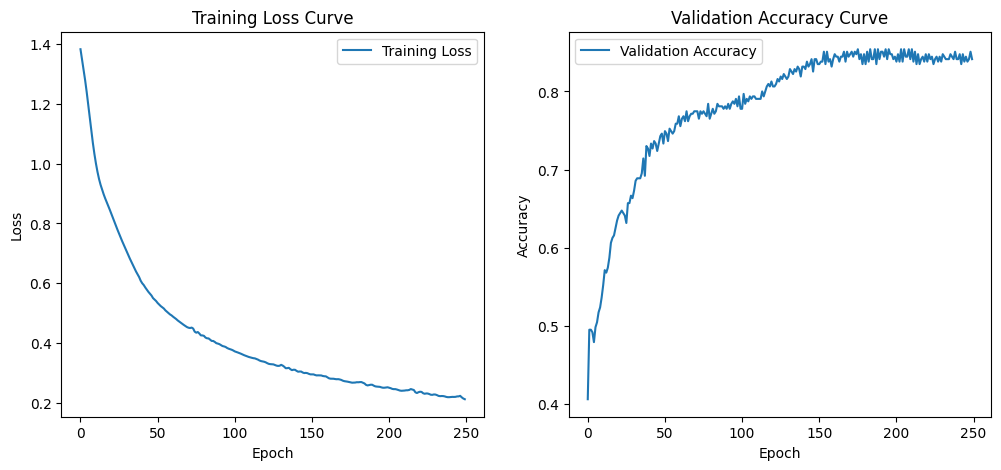

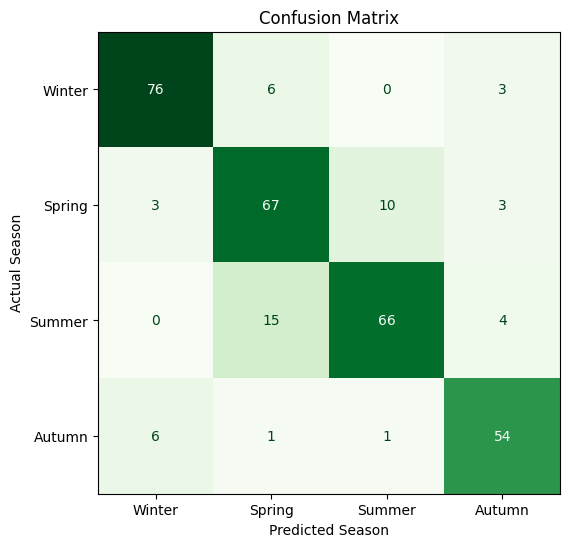

In [18]:
# Combine all training data
X_train = torch.cat([torch.tensor(train_x, dtype=torch.float32)], dim=0)
y_train = torch.cat([torch.tensor(train_y, dtype=torch.long)], dim=0)

X_val = torch.cat([torch.tensor(val_x, dtype=torch.float32)], dim=0)
y_val = torch.cat([torch.tensor(val_y, dtype=torch.long)], dim=0)

X_test = torch.cat([torch.tensor(test_x, dtype=torch.float32)], dim=0)
y_test = torch.cat([torch.tensor(test_y, dtype=torch.long)], dim=0)


hidden_size = 72
model = MLP(hidden_size=hidden_size)

criterion = nn.CrossEntropyLoss()
# Learning rate was chosen experimentally starting from 0.001
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=5e-5)

# Number of epochs was chosen experimentally such that increasing them would not improve the accuracy
epochs = 250
train_losses = []
val_accuracies = []

train(model, criterion, optimizer, train_losses, val_accuracies, X_train, y_train, X_val, y_val, epochs)

test_preds_mlp, test_accuracy = evaluate_model(model, X_test, y_test)

print(f"Final Test Accuracy: {test_accuracy:.4f}")

plot(train_losses, val_accuracies)
plot_confusion_matrix(y_test, test_preds_mlp)

# torch.save(model.state_dict(), "models/MLP.pth")

In [19]:
# prepare data for 1D-CNN with 3 channels
train_x = np.array(train_x)
val_x = np.array(val_x)
test_x = np.array(test_x)

train_x_reshaped = train_x.reshape(-1, 3, 24)
val_x_reshaped = val_x.reshape(-1, 3, 24)
test_x_reshaped = test_x.reshape(-1, 3, 24)

X_train = torch.tensor(train_x_reshaped, dtype=torch.float32)
X_val = torch.tensor(val_x_reshaped, dtype=torch.float32)
X_test = torch.tensor(test_x_reshaped, dtype=torch.float32)

y_train = torch.tensor(train_y, dtype=torch.long)
y_val = torch.tensor(val_y, dtype=torch.long)
y_test = torch.tensor(test_y, dtype=torch.long)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: torch.Size([1470, 3, 24])
y_train shape: torch.Size([1470])


In [20]:
class CNN_1D(nn.Module):
    def __init__(self):
        super(CNN_1D, self).__init__()
        self.conv1 = nn.Sequential(
            # (batch_size, 3, 24) -> (batch_size, 24, 22) 
            nn.Conv1d(in_channels=3, out_channels=24, kernel_size=3),
            # (batch_size, 24, 22) -> (batch_size, 24, 22) 
            nn.LeakyReLU(),
            # (batch_size, 24, 22) -> (batch_size, 24, 11) 
            nn.MaxPool1d(kernel_size=2, stride=2),
            # (batch_size, 24, 22) -> (batch_size, 24, 11)
            nn.BatchNorm1d(24)
        )
        self.conv2 = nn.Sequential(
            # (batch_size, 24, 11) -> (batch_size, 96, 9)
            nn.Conv1d(in_channels=24, out_channels=96, kernel_size=3),
            # (batch_size, 96, 9) -> (batch_size, 96, 9)
            nn.ReLU(),
            # (batch_size, 96, 9) -> (batch_size, 96, 4)
            nn.MaxPool1d(kernel_size=2, stride=2),
            # (batch_size, 96, 9) -> (batch_size, 96, 4)
            nn.Dropout1d(0.15)
        )
        # (batch_size, 96, 9) -> (batch_size, 1, 384)
        self.flatten = nn.Flatten()
        # (batch_size, 1, 384) -> (batch_size, 1, 4)
        self.fully_connected = nn.Linear(96*4, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fully_connected(x)
        return x


Epoch 1/250, Loss: 1.3484, Val Accuracy: 0.4571
Epoch 2/250, Loss: 1.2334, Val Accuracy: 0.5270
Epoch 3/250, Loss: 1.1392, Val Accuracy: 0.5397
Epoch 4/250, Loss: 1.0761, Val Accuracy: 0.5397
Epoch 5/250, Loss: 1.0312, Val Accuracy: 0.5333
Epoch 6/250, Loss: 0.9913, Val Accuracy: 0.5365
Epoch 7/250, Loss: 0.9660, Val Accuracy: 0.5270
Epoch 8/250, Loss: 0.9456, Val Accuracy: 0.5397
Epoch 9/250, Loss: 0.9182, Val Accuracy: 0.5397
Epoch 10/250, Loss: 0.8998, Val Accuracy: 0.5556
Epoch 11/250, Loss: 0.8859, Val Accuracy: 0.5683
Epoch 12/250, Loss: 0.8653, Val Accuracy: 0.5841
Epoch 13/250, Loss: 0.8508, Val Accuracy: 0.5968
Epoch 14/250, Loss: 0.8285, Val Accuracy: 0.5937
Epoch 15/250, Loss: 0.8232, Val Accuracy: 0.6159
Epoch 16/250, Loss: 0.8093, Val Accuracy: 0.6159
Epoch 17/250, Loss: 0.7907, Val Accuracy: 0.6317
Epoch 18/250, Loss: 0.7761, Val Accuracy: 0.6635
Epoch 19/250, Loss: 0.7645, Val Accuracy: 0.6667
Epoch 20/250, Loss: 0.7492, Val Accuracy: 0.6635
Epoch 21/250, Loss: 0.7427, V

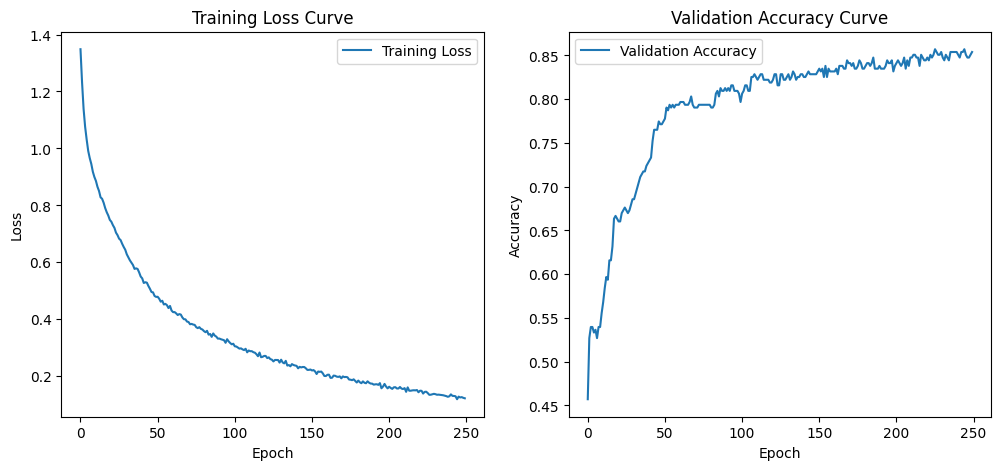

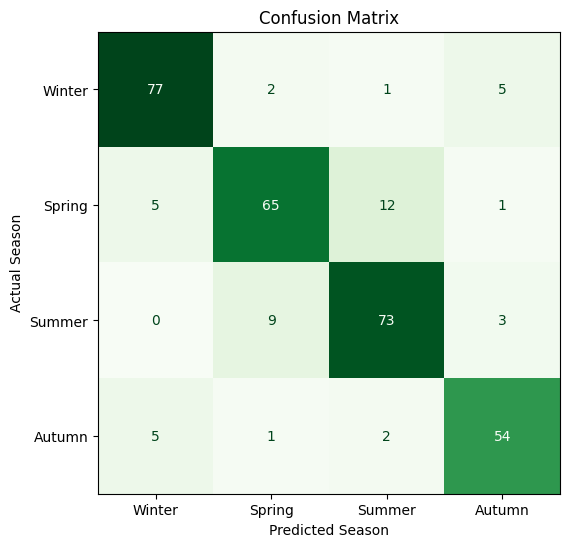

In [21]:
model = CNN_1D()
# Learning rate was chosen experimentally starting from 0.001
optimizer = optim.Adam(model.parameters(), lr=0.0015, weight_decay=1e-6)
# Number of epochs was chosen experimentally such that increasing them would not improve the accuracy
epochs = 250
train_losses = []
val_accuracies = []

train(model, criterion, optimizer, train_losses, val_accuracies, X_train, y_train, X_val, y_val, epochs)

test_preds_1D_CNN, test_accuracy = evaluate_model(model, X_test, y_test)

print(f"Final Test Accuracy: {test_accuracy:.4f}")

plot(train_losses, val_accuracies)
plot_confusion_matrix(y_test, test_preds_1D_CNN)
# torch.save(model.state_dict(), "models/1D_CNN.pth")

In [22]:
from pyts.image import GramianAngularField
from skimage.transform import resize

# Transforming each 24-hour time-series into a 2D “image” before feeding it into a 2D CNN.

# As this article says https://medium.com/analytics-vidhya/encoding-time-series-as-images-b043becbdbf3,
# 'A range of [-1, 1] is extremely desirable, if not necessary, as input range for Neural Networks.' 
# And GramianAngularField does exactly that

def transformToImage(data):
    # GramianAngularField with difference method gave the best accuracy results
    gaf = GramianAngularField(image_size=24, method='difference', sample_range = (-1, 1))

    gaf_transformed = []
    for feature_idx in range(data.shape[1]):     
        feature_gaf = gaf.transform(data[:, feature_idx, :])
        # image size will be 4x6
        feature_gaf = np.stack([resize(img, (4, 6)) for img in feature_gaf])
        gaf_transformed.append(np.expand_dims(feature_gaf, axis=1))

    data_gaf = np.concatenate(gaf_transformed, axis=1)
    print("Final shape:", data_gaf.shape)
    return data_gaf

In [23]:
# Convert to a PyTorch tensor
X_train = torch.tensor(transformToImage(train_x_reshaped), dtype=torch.float32)
X_val = torch.tensor(transformToImage(val_x_reshaped), dtype=torch.float32)
X_test = torch.tensor(transformToImage(test_x_reshaped), dtype=torch.float32)

Final shape: (1470, 3, 4, 6)
Final shape: (315, 3, 4, 6)
Final shape: (315, 3, 4, 6)


In [24]:
class CNN_2D(nn.Module):
    # hidden size was chosen experimentally
    def __init__(self, hidden_size=48):
        super(CNN_2D, self).__init__()

        self.conv1 = nn.Sequential(
            # (batch_size, 3, 4, 6) -> (batch_size, 48, 4, 6)
            nn.Conv2d(in_channels=3, out_channels=hidden_size, kernel_size=3, padding=1),
            # (batch_size, 3, 4, 6) -> (batch_size, 48, 4, 6)
            nn.BatchNorm2d(hidden_size),
            # (batch_size, 3, 4, 6) -> (batch_size, 48, 4, 6)
            nn.LeakyReLU(),
            # (batch_size, 3, 4, 6) -> (batch_size, 48, 2, 3)
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            # (batch_size, 48, 2, 3) -> (batch_size, 96, 2, 3)
            nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size * 2, kernel_size=3, padding=1),
            # (batch_size, 96, 2, 3) -> (batch_size, 96, 2, 3)
            nn.BatchNorm2d(hidden_size * 2),
            # (batch_size, 96, 2, 3) -> (batch_size, 96, 2, 3)
            nn.LeakyReLU(),
            # (batch_size, 96, 2, 3) -> (batch_size, 96, 1, 1)
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # (batch_size, 96, 1, 1) -> (batch_size, 96, 1, 1)
        self.dropout = nn.Dropout(0.3) # dropout rate chosen experimentally
        # (batch_size, 96, 1, 1) -> (batch_size, 96, 1, 1)
        self.flatten = nn.Flatten()
        # (batch_size, 96, 1, 1) -> (batch_size, 48, 1, 1)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        # (batch_size, 48, 1, 1) -> (batch_size, 4, 1, 1)
        self.fc2 = nn.Linear(hidden_size, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch 1/100, Loss: 1.4562, Val Accuracy: 0.2667
Epoch 2/100, Loss: 1.3237, Val Accuracy: 0.4984
Epoch 3/100, Loss: 1.2202, Val Accuracy: 0.4889
Epoch 4/100, Loss: 1.1426, Val Accuracy: 0.4984
Epoch 5/100, Loss: 1.0934, Val Accuracy: 0.5111
Epoch 6/100, Loss: 1.0727, Val Accuracy: 0.5111
Epoch 7/100, Loss: 1.0176, Val Accuracy: 0.5556
Epoch 8/100, Loss: 0.9823, Val Accuracy: 0.5556
Epoch 9/100, Loss: 0.9591, Val Accuracy: 0.5016
Epoch 10/100, Loss: 0.9327, Val Accuracy: 0.5016
Epoch 11/100, Loss: 0.9030, Val Accuracy: 0.4857
Epoch 12/100, Loss: 0.8564, Val Accuracy: 0.4317
Epoch 13/100, Loss: 0.8430, Val Accuracy: 0.3873
Epoch 14/100, Loss: 0.8210, Val Accuracy: 0.3175
Epoch 15/100, Loss: 0.7833, Val Accuracy: 0.2889
Epoch 16/100, Loss: 0.7669, Val Accuracy: 0.2762
Epoch 17/100, Loss: 0.7571, Val Accuracy: 0.2698
Epoch 18/100, Loss: 0.7414, Val Accuracy: 0.2635
Epoch 19/100, Loss: 0.7199, Val Accuracy: 0.2635
Epoch 20/100, Loss: 0.7112, Val Accuracy: 0.2921
Epoch 21/100, Loss: 0.6770, V

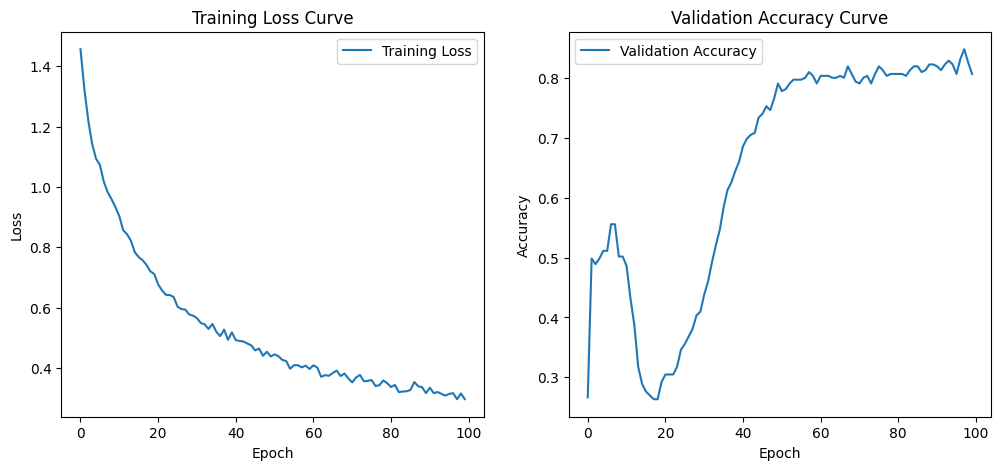

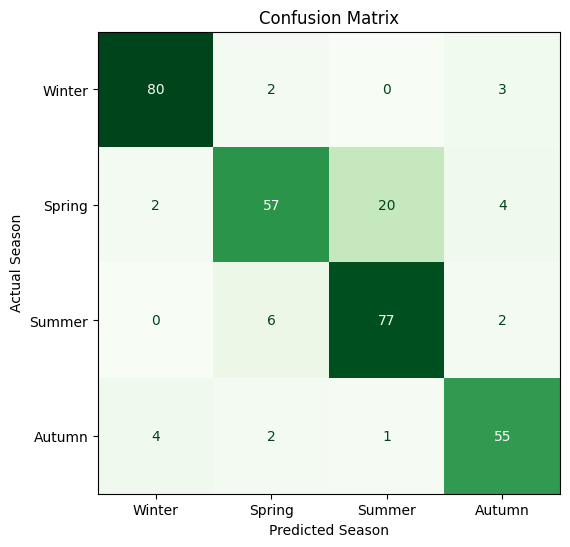

In [25]:
model = CNN_2D(hidden_size=96) 
# Learning rate was chosen experimentally starting from 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=8e-6) 
# Number of epochs was chosen experimentally such that increasing them would not improve the accuracy
epochs = 100 
train_losses = []
val_accuracies = []

train(model, criterion, optimizer, train_losses, val_accuracies, X_train, y_train, X_val, y_val, epochs)

test_preds_2D_CNN, test_accuracy = evaluate_model(model, X_test, y_test)

print(f"Final Test Accuracy: {test_accuracy:.4f}")

plot(train_losses, val_accuracies)
plot_confusion_matrix(y_test, test_preds_2D_CNN)
# torch.save(model.state_dict(), "models/2D_CNN.pth")